In [121]:
# Required libraries    
import matplotlib.pyplot as plt
import cv2
from cv2 import resize, GaussianBlur
from cv2 import erode, dilate
from sklearn.cluster import KMeans, MiniBatchKMeans
import time
import numpy as np
from scipy.io import loadmat
import os
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

In [58]:
rawMatData = loadmat('../03_CT_Scan_Images/Beta_1_0.2.mat')
bwImage = rawMatData["bwImage"]
ctImage = rawMatData["ctImage"]

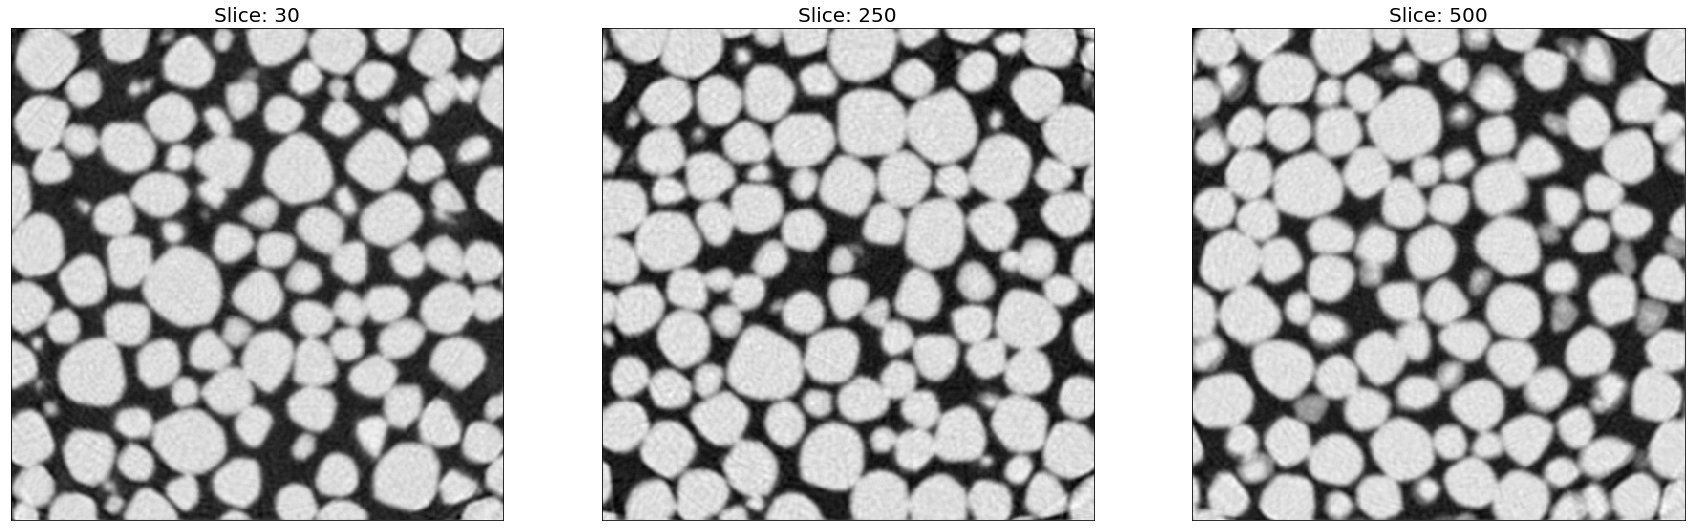

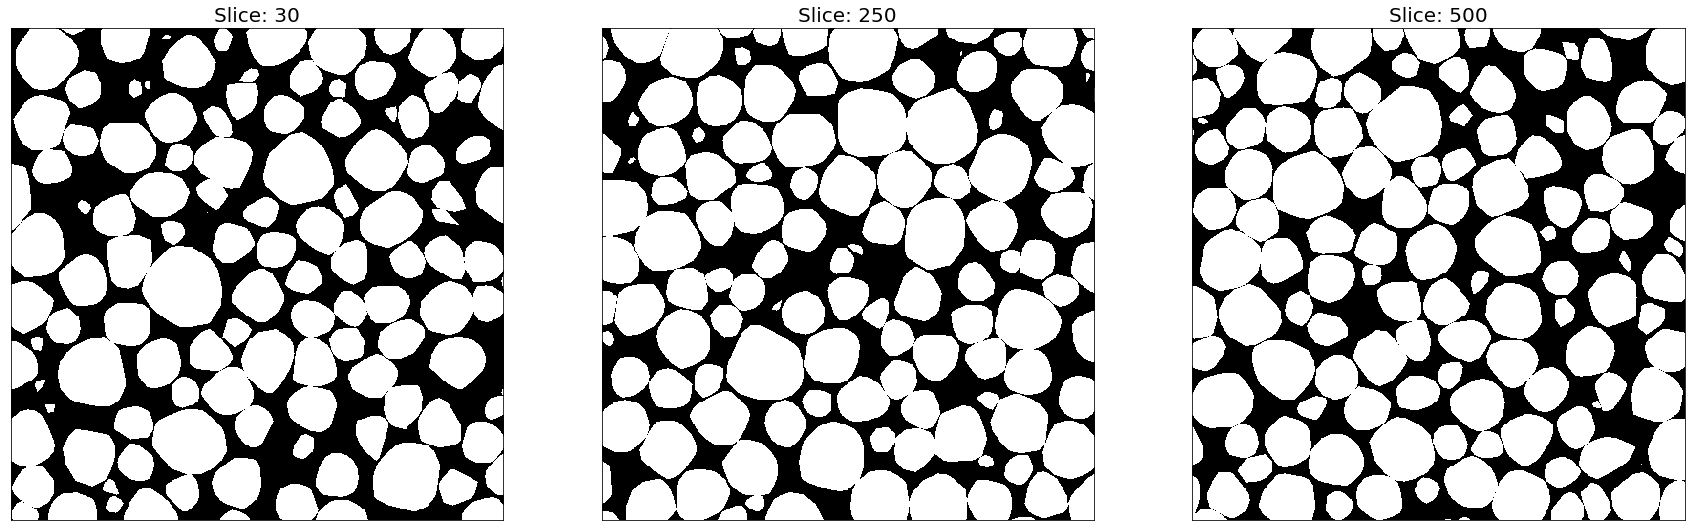

In [59]:
def PlotSlice(image, sliceNumber):
    plt.imshow(image[:,:,sliceNumber], cmap="gray")
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.title("Slice: " + str(sliceNumber), size=20)

def PlotImage(image):
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    PlotSlice(image, 30)
    plt.subplot(1,3,2)
    PlotSlice(image, 250)
    plt.subplot(1,3,3)
    PlotSlice(image, 500)

PlotImage(ctImage)
PlotImage(bwImage)

In [60]:
def one_hot_encode(kmeans_result):
    """
    One hot encodes an image;

    Parameters
    ----------
    kmeans_result : ndarray

    Returns
    -------
    encoded_image  : ndarray
        binary one-hot-encode masks
    """
    unique = np.unique(kmeans_result)
    colormap = {i:unique[i] for i in range(len(unique))}
    encoded_image = np.zeros(kmeans_result.shape[:2] + (len(colormap), ), dtype=np.float32)
    for i in range(encoded_image.shape[2]):
        encoded_image[:, :, i] = np.all(kmeans_result.reshape((-1, 1)) == colormap[i],
                                        axis=1).reshape(kmeans_result.shape[:2])
    return encoded_image

def clusterize(img_noback,n_clusters=3,
               batch_size = 500,
               mini_batch = True):
    """
    Clusterize image;
    Parameters
    ----------
    img_noback : ndarray

    Returns
    -------
    _ : ndarray
        one hot encoded binary masks of clustered image (1 binary masks per 1 cluster)
    time_1: float
        clusterization execution time
    """
    
    start = time.time()
    if mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42,
                                 batch_size = batch_size,n_init = 10).fit(img_noback.reshape(-1, 1))
    else:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, verbose=0,
                        random_state = 42).fit(img_noback.reshape(-1, 1))
    end = time.time()
    time_1 = end-start
    print('Kmeans take: ', np.round(time_1, 2))
    return one_hot_encode(kmeans.labels_.reshape(img_noback.shape[0], -1)), time_1

(516, 516)


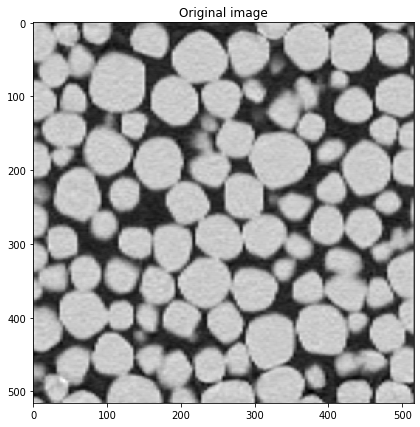

In [115]:
id_ = 500

image = ctImage[id_,:,:]
print(image.shape)
bw_imag_orig = bwImage[id_,:,:]
pixel_vals = image.reshape((-1,1)) 
  
# Convert to float type 
pixel_vals = np.float32(pixel_vals)
plt.figure(figsize = (7,7))
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()

## Test bilateral + Sharpen filters

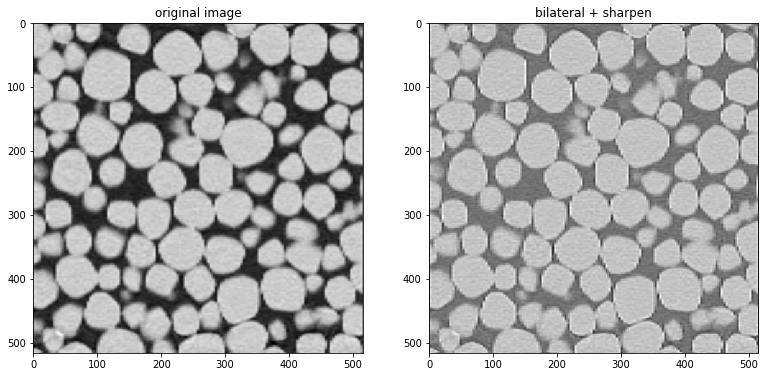

Kmeans take:  0.27
Prosity clustered: 0.31492248062015504
Prosity original: 0.3094690823868758


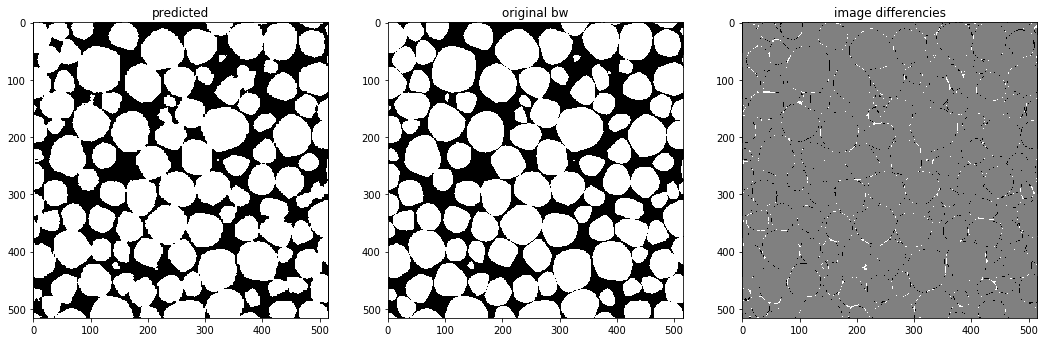

In [117]:
filter_ = True # whetrer to apply sharpen filter to bilateral or not

kernel = np.array([[-1,-1,-1], 
                   [-1, 9,-1],
                   [-1,-1,-1]])
size_fig = 13
    
bilateral = cv2.bilateralFilter(np.float32(image), 3, 25, 25) 
sharpened = cv2.filter2D(bilateral, -1, kernel)
fig, axs = plt.subplots(1, 2, figsize=(size_fig, size_fig))

axs[0].imshow(image, cmap='gray'), axs[0].set_title('original image')
axs[1].imshow(sharpened, cmap='gray'), axs[1].set_title('bilateral')
if filter_:
    axs[1].set_title('bilateral + sharpen')

plt.show()

# without filtering
if filter_:
    encoded_image, time_1 = clusterize(sharpened, batch_size = 800, n_clusters = 2)
else:
    encoded_image, time_1 = clusterize(bilateral, batch_size = 800, n_clusters = 2)

num_encoded_imgs = encoded_image.shape[2]

fig, axs = plt.subplots(1, 3, figsize=(size_fig+5, size_fig+5))
if np.sum(encoded_image[:, :, 0]==0) > np.sum(encoded_image[:, :, 1]==0):
    ax_id = 1
else:
    ax_id = 0
    
axs[0].imshow(encoded_image[:, :, ax_id], cmap='gray'),
axs[0].set_title('predicted')
porosity_pred = np.sum(encoded_image[:, :, ax_id]==0)/np.prod(encoded_image[:, :, ax_id].shape)
print("Prosity clustered: " + str(porosity_pred))
axs[1].imshow(bw_imag_orig, cmap='gray'),
axs[1].set_title('original bw')
porosity = np.sum(bw_imag_orig==0)/np.prod(bw_imag_orig.shape)
print("Prosity original: " + str(porosity))
err = (encoded_image[:, :, ax_id] - bw_imag_orig)
axs[2].imshow(err, cmap = 'gray'), axs[2].set_title('image differencies')
plt.show()


In [50]:
np.sum(err!=0)/np.prod(err.shape)

0.04645153536446127

## Watershed algorithm

Text(0.5, 1.0, 'Separated objects')

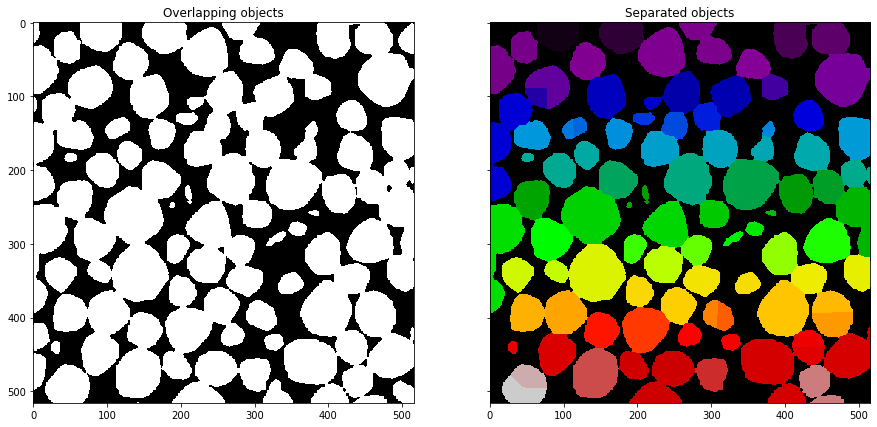

In [51]:
foot = 20
img = encoded_image[:, :, ax_id]
distance = ndi.distance_transform_edt(img)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((foot, foot)),
                            labels=img)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=img)

fig, axes = plt.subplots(ncols=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Separated objects')

## Other filters

### Test Sobel operator to detect edges

Kmeans take:  0.13


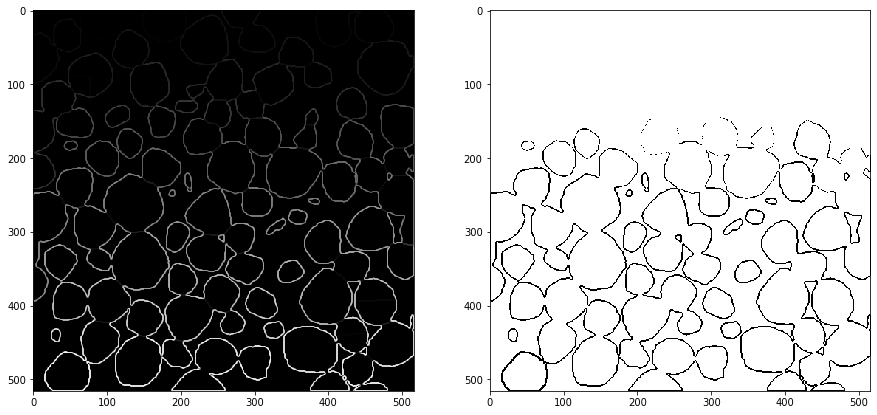

In [57]:
# Get x-gradient
grad_x = ndimage.sobel(np.float32(labels),axis=0,mode='constant')
# Get y-gradient
grad_y = ndimage.sobel(np.float32(labels),axis=1,mode='constant')

# Get square root of sum of squares
sobel=np.hypot(grad_x,grad_y)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(sobel, cmap = 'gray')

sobel_encoded, time_1 = clusterize(sobel, batch_size = 800,
                                   n_clusters = 2)
axs[1].imshow(sobel_encoded[:, :, 1], cmap='gray')
plt.show()

## Apply erosion and dilation

Kmeans take:  0.13
Prosity clustered no filters: 0.32098056006249626
Prosity after erosion + dilation: 0.3823500691064239
Prosity original: 0.3094690823868758


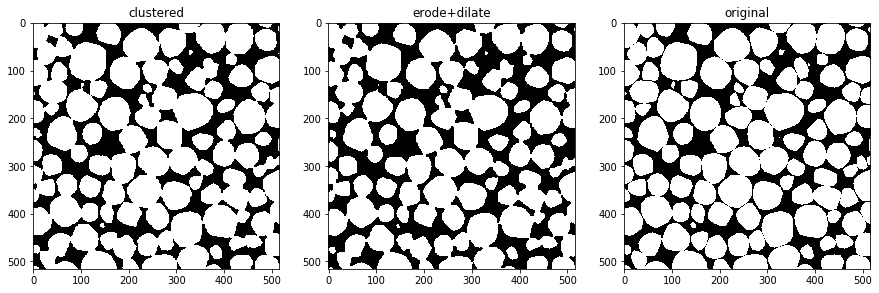

In [118]:
encoded_image, time_1 = clusterize((image), batch_size = 800, n_clusters = 2)

num_encoded_imgs = encoded_image.shape[2]

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
if np.sum(encoded_image[:, :, 0]==0) > np.sum(encoded_image[:, :, 1]==0):
    ax_id = 1
else:
    ax_id = 0
    
axs[0].imshow(encoded_image[:, :, ax_id], cmap='gray'),
axs[0].set_title('clustered')
porosity = np.sum(encoded_image[:, :, ax_id]==0)/np.prod(encoded_image[:, :, ax_id].shape)
print("Prosity clustered no filters: " + str(porosity))

kernel_erode = np.ones((2,2), np.uint8)
kernel_dilate = np.ones((2, 2), np.uint8)

img = erode(encoded_image[:, :, ax_id].astype("uint8"), kernel_erode, iterations=3)
img = dilate(img, kernel_dilate, iterations=1).astype("uint8")
porosity = np.sum(img==0)/np.prod(img.shape)
print("Prosity after erosion + dilation: " + str(porosity))
axs[1].imshow(img, cmap = 'gray'), axs[1].set_title('erode+dilate')

axs[2].imshow(bw_imag_orig, cmap='gray'),
axs[2].set_title('original')
porosity = np.sum(bw_imag_orig==0)/np.prod(bw_imag_orig.shape)
print("Prosity original: " + str(porosity))
plt.show()

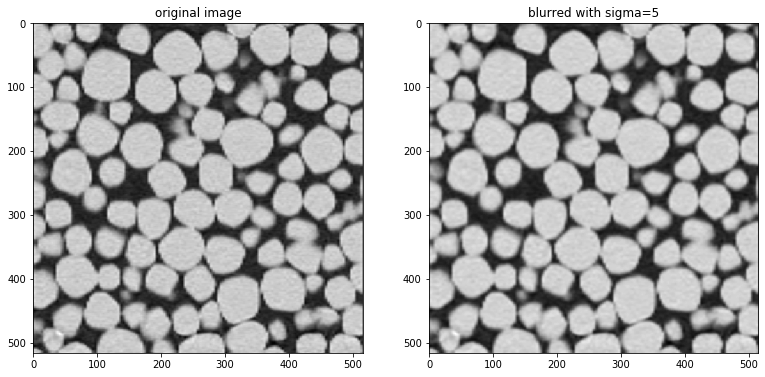

Kmeans take:  0.14
Prosity blurred: 0.3234293311700018
Prosity original: 0.3094690823868758


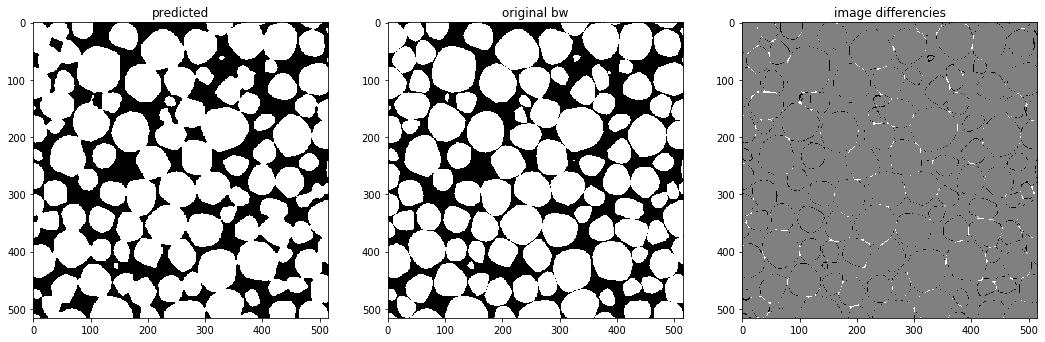

In [119]:
blur_filter_value = 5

blur_im = GaussianBlur(image, (blur_filter_value, blur_filter_value), 0)
size_fig = 13
    
fig, axs = plt.subplots(1, 2, figsize=(size_fig, size_fig))

axs[0].imshow(image, cmap='gray'), axs[0].set_title('original image')
axs[1].imshow(blur_im, cmap='gray'), axs[1].set_title('blurred with sigma='+ str(blur_filter_value))

plt.show()

# without filtering
encoded_image, time_1 = clusterize(blur_im, batch_size = 800, n_clusters = 2)

num_encoded_imgs = encoded_image.shape[2]

fig, axs = plt.subplots(1, 3, figsize=(size_fig+5, size_fig+5))
if np.sum(encoded_image[:, :, 0]==0) > np.sum(encoded_image[:, :, 1]==0):
    ax_id = 1
else:
    ax_id = 0
    
axs[0].imshow(encoded_image[:, :, ax_id], cmap='gray'),
axs[0].set_title('predicted')
porosity_pred = np.sum(encoded_image[:, :, ax_id]==0)/np.prod(encoded_image[:, :, ax_id].shape)
print("Prosity blurred: " + str(porosity_pred))
axs[1].imshow(bw_imag_orig, cmap='gray'),
axs[1].set_title('original bw')
porosity = np.sum(bw_imag_orig==0)/np.prod(bw_imag_orig.shape)
print("Prosity original: " + str(porosity))
err = (encoded_image[:, :, ax_id] - bw_imag_orig)
axs[2].imshow(err, cmap = 'gray'), axs[2].set_title('image differencies')
plt.show()

